In [1]:
!ls

Explore Holzer 2021 Fluxes.ipynb OCIM2_48L_base_transport.mat
OCIM2_48L_base_data.nc


In [2]:
from scipy.io import loadmat

#Units of "per year" for the transport matrix
base_transport = loadmat("OCIM2_48L_base_transport.mat")

In [3]:
import numpy as np

negative_offdiagonal = [(row, col)
  for row,col in zip(*np.nonzero(base_transport['TR'] < 0))
  if row != col]

print(len(negative_offdiagonal))

2342846


In [4]:
neg_offdiag_rows, neg_offdiag_cols = list(zip(*negative_offdiagonal))
np.min(base_transport['TR'][neg_offdiag_rows, neg_offdiag_cols])

-291.8421788096676

In [8]:
mod_base_transport = base_transport['TR'].copy()
mod_base_transport[(np.arange(mod_base_transport.shape[0]),
                    np.arange(mod_base_transport.shape[0]))] = 0.0

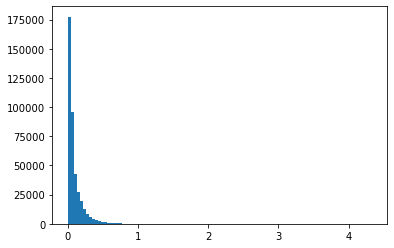

In [14]:
from matplotlib import pyplot as plt

plt.hist(np.min(mod_base_transport, axis=1).toarray().squeeze()/base_transport['TR'].diagonal(),
         bins=100)
plt.show()

In [15]:
print(np.min(mod_base_transport))

-291.8421788096676


In [16]:
from netCDF4 import Dataset

In [18]:
data = Dataset("OCIM2_48L_base_data.nc")
tridx_to_fullgrid_idxs = np.nonzero(data.variables['ocnmask'][:].data)

In [68]:
data.variables['vol']

<class 'netCDF4._netCDF4.Variable'>
float64 vol(depth, longitude, latitude)
    description: volume (m^3) of tracer grid cells
unlimited dimensions: 
current shape = (48, 180, 91)
filling on, default _FillValue of 9.969209968386869e+36 used

In [19]:
cell_volumes = data.variables['vol'][:,:,:].data[tridx_to_fullgrid_idxs]

In [159]:
import scipy.sparse

#Row = 'to', col = 'from'.
#Right now the matrix volumes are normalized relative to the row volume
print("When relative to row volume...")
print("max abs col sum", np.max(np.abs(np.sum(base_transport['TR'], axis=0))))
print("max abs row sum", np.max(np.abs(np.sum(base_transport['TR'], axis=1))))
print("Converting to m3/yr units")
#Multiplying by the row volumes gives...column normalization, but breaks row norm due to
# numerical precision issues?
print("max abs col sum", np.max(np.abs(np.sum(scipy.sparse.diags(cell_volumes) @ base_transport['TR'], axis=0))))
print("max abs row sum", np.max(np.abs(np.sum(scipy.sparse.diags(cell_volumes) @ base_transport['TR'], axis=1))))

When relative to row volume...
max abs col sum 15442.452583128634
max abs row sum 2.910581457626904e-05
Converting to m3/yr units
max abs col sum 49.210479736328125
max abs row sum 727265.9297075272


<class 'netCDF4._netCDF4.Variable'>
float64 ocnmask(depth, longitude, latitude)
    description: land-sea mask (1 = ocean, 0 = land)
unlimited dimensions: 
current shape = (48, 180, 91)
filling on, default _FillValue of 9.969209968386869e+36 used
405386.0
(array([ 0,  0,  0, ..., 47, 47, 47]), array([  0,   0,   0, ..., 151, 151, 151]), array([ 9, 10, 11, ..., 57, 58, 59]))


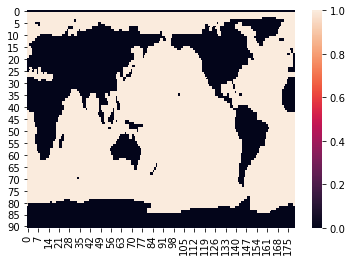

In [27]:
import numpy as np
print(data.variables['ocnmask'])
type(data.variables['ocnmask'][:].data)
print(np.sum(data.variables['ocnmask'][:].data))
print(np.nonzero(data.variables['ocnmask'][:].data))

from matplotlib import pyplot as plt
import seaborn as sns
sns.heatmap(data.variables['ocnmask'][0].data[:,::-1].transpose())
plt.show()

In [37]:
ulat = data.variables['ulon'][:,:,:].data #stored weirdly
ulon = data.variables['ulat'][:,:,:].data
wz = data.variables['wz'][:,:,:].data

In [38]:
print(np.max(ulon))
print(np.max(ulat))
print(np.max(wz))

360.0
90.0
5413.834403016414


In [86]:
ocnmask = data.variables['ocnmask'][:].data
ocnmask.shape

(48, 180, 91)

In [184]:
#figure out the index mapping from tr idx to full grid points via np.nonzero on ocean mask
tridx_to_fullgrid_idxs = np.nonzero(ocnmask)

#Let's populat a data structure called 'gridflux' that's as follows:
# [from_depthidx, from_lonidx, from_latidx] -> [trentry...]
# Where 'trentry' looks like (flux, (to_depthidx, to_lonidx, to_latidx))

#initialize the gridflux data structure

def initialize_grid(shape):
    grid = []
    for depth_idx in range(shape[0]):
        grid_depthentry = []
        for lon_idx in range(shape[1]):
            grid_lonentry = []
            for lat_idx in range(shape[2]):
                grid_latentry = []
                grid_lonentry.append(grid_latentry)
            grid_depthentry.append(grid_lonentry)
        grid.append(grid_depthentry)
    return grid

net_gridflux = initialize_grid(ocnmask.shape)

SVERDRUP_CONVERSION = 1000000*(365*24*60*60) #m3 per year in sverdrups

TR_mat_unnorm = ((scipy.sparse.diags(cell_volumes) @ base_transport['TR'])/SVERDRUP_CONVERSION)
TR_mat_net = TR_mat_unnorm - TR_mat_unnorm.transpose()

TR_mat_net_coo = TR_mat_net.tocoo()
tr_cols, tr_rows, tr_data = TR_mat_net_coo.col, TR_mat_net_coo.row, TR_mat_net_coo.data
for (tr_col, tr_row, flux) in zip(tr_cols, tr_rows, tr_data):
    if (flux != 0): #expect zeros along diagonal
        from_depthidx = tridx_to_fullgrid_idxs[0][tr_col] #need to verify from & to by visualizing
        from_lonidx = tridx_to_fullgrid_idxs[1][tr_col]
        from_latidx = tridx_to_fullgrid_idxs[2][tr_col]

        to_depthidx = tridx_to_fullgrid_idxs[0][tr_row]
        to_lonidx = tridx_to_fullgrid_idxs[1][tr_row]
        to_latidx = tridx_to_fullgrid_idxs[2][tr_row]
    #else:
    #    flux = -flux
    #    from_depthidx = tridx_to_fullgrid_idxs[0][tr_row] #need to verify from & to by visualizing
    #    from_lonidx = tridx_to_fullgrid_idxs[1][tr_row]
    #    from_latidx = tridx_to_fullgrid_idxs[2][tr_row]
    #    to_depthidx = tridx_to_fullgrid_idxs[0][tr_col]
    #    to_lonidx = tridx_to_fullgrid_idxs[1][tr_col]
    #    to_latidx = tridx_to_fullgrid_idxs[2][tr_col]
        
        #Make sure that the 'to' boxes are adjacent to the 'from' boxes
        assert ((abs(to_depthidx-from_depthidx) <= 2) or
                (max(to_depthidx,from_depthidx)==(ocnmask.shape[0]-1) 
                 and min(to_depthidx,from_depthidx)==0)), (to_depthidx, from_depthidx)
        assert ((abs(to_lonidx-from_lonidx) <= 1) or
                (max(to_lonidx,from_lonidx)==(ocnmask.shape[1]-1) 
                 and min(to_lonidx,from_lonidx)==0)), (to_lonidx, from_lonidx)
        assert ((abs(to_latidx-from_latidx) <= 1) or
                (max(to_latidx,from_latidx)==(ocnmask.shape[2]-1) 
                 and min(to_latidx,from_latidx)==0)), (to_latidx, from_latidx)

        net_gridflux[from_depthidx][from_lonidx][from_latidx].append( (flux, (to_depthidx, to_lonidx, to_latidx)) )
        #to_gridflux[to_depthidx][to_lonidx][to_latidx].append( (flux, (from_depthidx, from_lonidx, from_latidx)) )
                

#and MOC

#then retrieve lat, lon, depth, pdens? (for uv vector?) for the flux axis
#then pick a box for the target...backtrack source?

In [211]:

Flux = namedtuple("Flux",
                      ["west", "east", "north", "south", "up", "down",
                       "from_lat", "from_lon", "from_depth", "upwellto"])


def get_fluxes_at_depth(depthidx, lon_min, lon_max, lat_min, lat_max):
    #global vars: net_gridflux, ulat, ulon, wz
    fluxes = []
    for from_lonidx in range(len(net_gridflux[depthidx])):
        for from_latidx in range(len(net_gridflux[depthidx][from_lonidx])):
            from_lat = ulat[depthidx, from_lonidx, from_latidx]
            from_lon = ulon[depthidx, from_lonidx, from_latidx]
            from_depth = wz[depthidx, from_lonidx, from_latidx]    
            if (from_lon >= lon_min and from_lon <= lon_max and from_lat >= lat_min and from_lat <= lat_max):
                net_westflux = 0
                net_eastflux = 0
                net_northflux = 0
                net_southflux = 0
                net_upflux = 0
                net_downflux = 0   
                net_upwelltoflux = 0 #upwellto terminates at the from cell
                for (flux, (to_depthidx, to_lonidx, to_latidx)) in net_gridflux[DEPTHIDX][from_lonidx][from_latidx]:
                    if (flux > 0):
                        to_lat = ulat[depthidx, to_lonidx, to_latidx]
                        to_lon = ulon[depthidx, to_lonidx, to_latidx]    
                        to_depth = wz[depthidx, to_lonidx, to_latidx]
                        if (abs(to_latidx-from_latidx) <= 1 and abs(to_lonidx-from_lonidx) <= 1):
                            if (to_lonidx < from_lonidx):
                                net_westflux += flux
                            if (to_lonidx > from_lonidx):
                                net_eastflux += flux
                            if (to_latidx < from_latidx):
                                net_southflux += flux
                            if (to_latidx > from_latidx):
                                net_northflux += flux
                            if (to_depthidx > DEPTHIDX):
                                net_downflux += flux
                            if (to_depthidx < DEPTHIDX):
                                net_upflux += flux
                            #quiver_starty.append(from_lat + (to_latidx-from_latidx)*0.5)
                            #quiver_startx.append(from_lon + (to_lonidx-from_lonidx)*0.5)
                            #quiver_ydel.append(np.sign(to_latidx-from_latidx)*flux)
                            #quiver_xdel.append(np.sign(to_lonidx-from_lonidx)*flux)
                    elif (flux < 0):
                        if (to_depthidx > from_depthidx):
                            net_upwelltoflux += abs(flux)
                fluxes.append(Flux(west=net_westflux, east=net_eastflux, north=net_northflux,
                                   south=net_southflux, up=net_upflux, down=net_downflux,
                                   upwellto=net_upwelltoflux,
                                   from_lat=from_lat, from_lon=from_lon, from_depth=from_depth))   
    return fluxes


def generate_fluxplot_at_depth(depthidx, lon_min, lon_max, lat_min, lat_max):
    
    #global vars: ulon, ulat, ocnmask
    lon_grid_at_depth = ulon[depthidx].ravel()
    lat_grid_at_depth = ulat[depthidx].ravel()
    range_mask = ((lon_grid_at_depth > lon_min)*(lon_grid_at_depth < lon_max)
                  *(lat_grid_at_depth > lat_min)*(lat_grid_at_depth < lat_max))
    lon_grid = lon_grid_at_depth[range_mask]
    lat_grid = lat_grid_at_depth[range_mask]
    land_grid = (ocnmask[depthidx].ravel())[range_mask]
    
    fluxes = get_fluxes_at_depth(depthidx=depthidx, lon_min=lon_min, lon_max=lon_max,
                                 lat_min=lat_min, lat_max=lat_max)
    
    upwelling_x = []
    upwelling_y = []
    upwelling_flux = []

    lateral_quiverx = []
    lateral_quivery = []
    lateral_quiver_xdel = []
    lateral_quiver_ydel = []
    LATERAL_OFFSET = 0.2

    for flux in fluxes:
        if (flux.west > 0):
            lateral_quiverx.append(flux.from_lon - LATERAL_OFFSET)
            lateral_quivery.append(flux.from_lat)
            lateral_quiver_xdel.append(-flux.west)
            lateral_quiver_ydel.append(0)
        if (flux.east > 0):
            lateral_quiverx.append(flux.from_lon + LATERAL_OFFSET)
            lateral_quivery.append(flux.from_lat)
            lateral_quiver_xdel.append(flux.east)
            lateral_quiver_ydel.append(0)
        if (flux.south > 0):
            lateral_quiverx.append(flux.from_lon)
            lateral_quivery.append(flux.from_lat - LATERAL_OFFSET)
            lateral_quiver_xdel.append(0)
            lateral_quiver_ydel.append(-flux.south)
        if (flux.north > 0):
            lateral_quiverx.append(flux.from_lon)
            lateral_quivery.append(flux.from_lat + LATERAL_OFFSET)
            lateral_quiver_xdel.append(0)
            lateral_quiver_ydel.append(flux.north)
        if (flux.down > 0 or flux.upwellto > 0):
            upwelling_x.append(flux.from_lon)
            upwelling_y.append(flux.from_lat)
            upwelling_flux.append(flux.upwellto - flux.down)
            
    plt.figure(figsize=(20,20))
    plt.title("Avg depth: "+str(np.mean([flux.from_depth for flux in fluxes])))

    plt.scatter(lon_grid.ravel()[land_grid==0],
                lat_grid.ravel()[land_grid==0], color="black",
                marker="s", s=100, alpha=0.1)

    plt.quiver(lateral_quiverx, lateral_quivery, lateral_quiver_xdel, lateral_quiver_ydel,
               scale_units='xy',
               #scale=(1/5.0)*(max(np.max(quiver_xdel), np.max(quiver_ydel)))
              )
    plt.show()

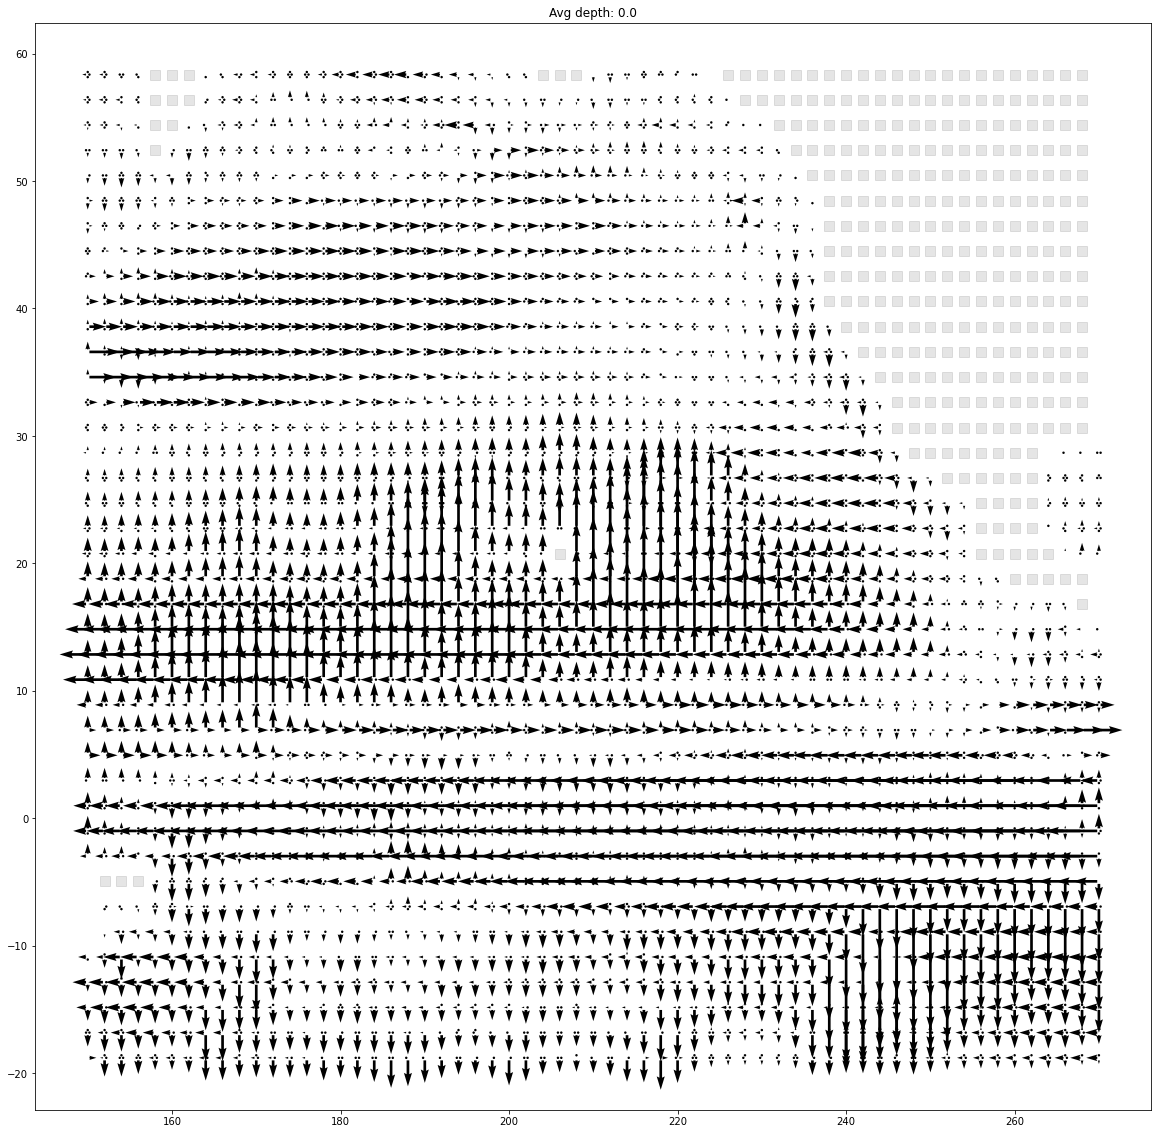

In [212]:
# visualize surface flows

from collections import namedtuple

DEPTHIDX = 0

lon_min = 150
lon_max = 270
lat_min = -20
lat_max = 60


generate_fluxplot_at_depth(depthidx=DEPTHIDX,
                           lon_min=lon_min, lon_max=lon_max,
                           lat_min=lat_min, lat_max=lat_max)

In [196]:
np.max(upwelling_flux)

-6.144247516257481e-05

In [129]:
fluxes

[]

In [50]:
ocnmask[:].data.ravel()

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
data.variables